<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/02_TC1_PCA%26tSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the libraries
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)
#TC1data15 = sfeatures1
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.897300,0.000000,1.829995,0.656801,0.001333,0.528604,2.618544,1.993496,1.487510,1.049062,0.000000,0.258848,1.455348,0.853410,1.215961,0.000000,0.571925,0.644190,0.536399,0.215012,0.0,1.704930,2.033992,2.059344,0.000000,0.000000,0.0,0.0,0.811806,1.861269,1.084387,2.724172,1.159409,0.000000,0.000000,0.193960,1.282674,0.685311,0.463778,0.899169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [6]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')
outcome

,Project_id_name,Project_id
0,TCGA-OV,10
1,TCGA-OV,10
2,TCGA-OV,10
3,TCGA-OV,10
4,TCGA-OV,10
...,...,...
4495,TCGA-LIHC,7
4496,TCGA-LIHC,7
4497,TCGA-LIHC,7
4498,TCGA-LIHC,7


In [ ]:
#outcome = outcome.values
#outcome = outcome['Project_id_name']

In [7]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded



# Feature Selection(PCA) + t-SNE

In [8]:
import importlib
from google.colab import files
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/FNL_TC1')
import tc1_library
importlib.reload(tc1_library);
import sklearn.decomposition as sk_decomp



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* add label for plot
* what can we learn from the figure from the groups that are overlap, are these related with each other


In [9]:
def plot_unsupervised_learning_results(unsupervised_learning_results, labels):
	'''
	Plot results from unsupervised learning analyses such as PCA or tSNE, overplotting the color/style of the markers based on known labels.
	'''

	# Import relevant libraries
	import seaborn as sns
	import matplotlib.pyplot as plt
	import matplotlib.lines as mpl_lines

	# Get a reasonable set of markers and color palette
	markers = mpl_lines.Line2D.filled_markers
	nclasses = len(set(labels))
	marker_list = (markers * int(nclasses/len(markers)+1))[:nclasses]
	color_palette = sns.color_palette("hls", nclasses)

	# Plot results
	_, ax = plt.subplots(figsize=(12,7.5), facecolor='w')
	ax = sns.scatterplot(x=unsupervised_learning_results[:,0], y=unsupervised_learning_results[:,1], hue=labels, style=labels, palette=color_palette, legend='full', alpha=1, markers=marker_list, edgecolor='k', ax=ax)
	ax.legend(bbox_to_anchor=(1,1))
	return(ax)


def run_and_plot_pca_and_tsne(X, y, top_n_features=500):
	'''
	Run PCA and tSNE analyses on data X and plot the results with marker color/style by known labels y.
	Note that tSNE takes long if using many features, so for tSNE we use the top-top_n_features-variance genes.
	'''

	# Sort the features by decreasing variance
	X_by_variance = X.loc[:,[x for x in X.var().sort_values(ascending=False).index]]

	# Perform the PCA using scikit-learn
	import sklearn.decomposition as sk_decomp
	pca = sk_decomp.PCA(n_components=10)
	pca_results = pca.fit_transform(X_by_variance)
	print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
	ax = plot_unsupervised_learning_results(pca_results, y)
	ax.set_title('PCA')

	# Perform tSNE using scikit-learn
	import sklearn.manifold as sk_manif
	tsne = sk_manif.TSNE(n_components=2)
	tsne_results = tsne.fit_transform(X_by_variance.iloc[:,:top_n_features])
	ax = plot_unsupervised_learning_results(tsne_results, y)
	ax.set_title('tSNE (using top-{}-variance features)'.format(top_n_features))

In [10]:
id_name = outcome.drop_duplicates().sort_values('Project_id')['Project_id_name']
id_name = list(id_name)

Top 10 PCA explained variance ratios: [0.11951665 0.10788788 0.05949288 0.05309376 0.04052011 0.03719555
 0.02759182 0.02507799 0.02285892 0.01953212]


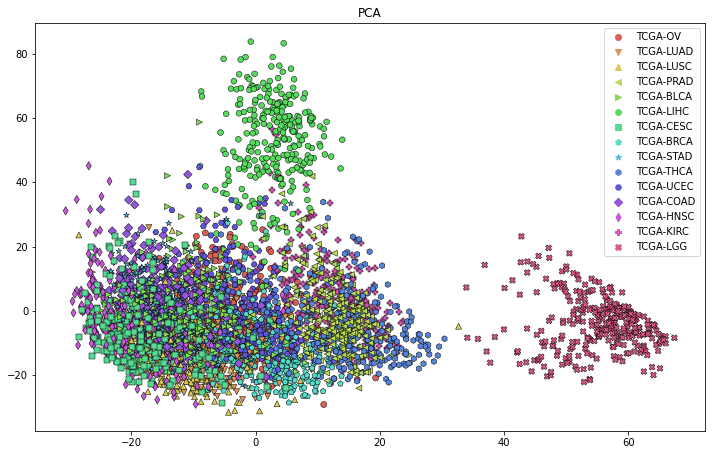

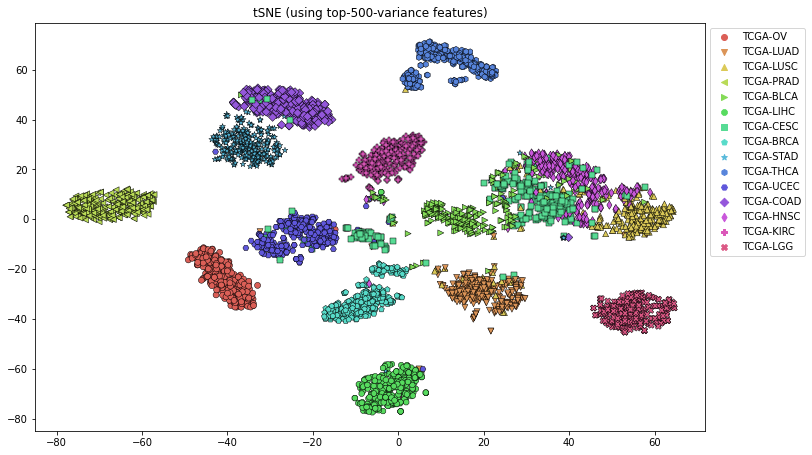

In [12]:
run_and_plot_pca_and_tsne(TC1data15, outcome['Project_id_name'])

## PCA

The loadings describe how much each variable contributes to a particular principal component. Large loadings (positive or negative) indicate that a particular variable has a strong relationship to a particular principal component. The sign of a loading indicates whether a variable and a principal component are positively or negatively correlated.

In [13]:
# TC1data15.columns = TC1data15_names

In [14]:
pca = PCA(0.95)
pca_results = pca.fit_transform(TC1data15)


In [15]:
loadings = pd.DataFrame(pca.components_.T, index=TC1data15.columns)
loadings

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945
TSPAN6,0.001059,-0.000904,0.000494,-0.006398,0.001234,-0.005441,-0.008869,-0.001303,-0.007121,-0.006875,-0.007689,-0.006086,0.002866,0.004568,0.011646,0.005189,-0.007372,0.012297,-0.007057,0.027040,-0.005308,-0.006578,0.000874,0.005239,0.006431,0.003898,-0.008602,-0.005038,-0.001966,-0.002798,-0.003439,0.002800,-0.005402,-0.002141,-0.002727,0.006299,-0.001182,-0.004754,0.005889,-0.002249,...,0.000711,-0.004682,-0.002901,0.001966,0.010399,0.013473,-0.007409,0.001183,0.003896,-0.007422,0.004689,-0.007736,-0.002603,0.004169,-0.001721,0.000288,-0.006169,-0.012097,-0.006189,-0.002538,-0.011495,0.001125,-0.004551,0.012822,0.000266,0.003859,-0.006237,0.003620,0.009574,0.006846,0.005926,0.005137,-0.007586,-0.014260,-0.002450,0.001046,0.000483,-0.006800,-0.006220,0.003201
TNMD,-0.000056,-0.000431,0.002453,-0.000526,0.002518,-0.000661,-0.000448,0.001281,0.002550,-0.002433,-0.003111,0.001905,-0.000355,-0.001786,0.002633,-0.002416,-0.000456,-0.002413,0.001694,0.009876,0.000615,-0.001678,0.001781,0.004069,0.000310,-0.000984,0.000647,-0.001470,-0.000282,0.001853,0.000104,0.001163,-0.003822,0.000124,-0.002395,-0.002315,0.002473,-0.002534,0.003362,0.000601,...,0.009568,0.003900,-0.006376,0.012941,-0.000744,-0.005351,-0.004320,-0.001353,0.002005,-0.002995,-0.006801,0.010647,0.004733,-0.000075,-0.000293,0.007937,-0.015997,0.002241,-0.008042,-0.013942,-0.009555,-0.011741,-0.000536,-0.006079,-0.000798,-0.003353,-0.000460,0.001078,0.013193,-0.002707,0.004069,-0.003935,0.002023,-0.012519,0.006703,-0.012236,-0.009225,0.003262,0.005443,-0.000905
DPM1,-0.004084,-0.005749,-0.001141,-0.001792,0.002133,-0.003579,-0.007833,-0.001708,-0.002476,0.003542,-0.003817,-0.000154,0.006368,-0.011639,0.004434,0.003368,-0.001082,-0.000703,-0.002268,0.008618,0.003264,-0.009184,0.000797,-0.004196,-0.005765,0.000224,-0.000132,0.001756,-0.004621,0.000531,0.003257,-0.000928,-0.005083,0.003747,0.000607,0.004139,-0.002881,-0.007952,0.006643,0.005803,...,-0.003012,-0.003065,-0.001181,-0.004323,-0.003386,-0.000840,0.003357,0.004242,-0.001673,-0.003914,-0.005598,-0.001029,-0.000489,0.001613,-0.000013,-0.002041,0.001709,0.002094,-0.008280,-0.000391,0.001286,0.001539,0.000495,-0.000167,0.000490,-0.000910,0.001681,0.003010,0.003085,-0.002407,0.000175,-0.000925,0.001821,0.001982,-0.000179,0.002356,0.000382,-0.001602,0.001822,0.002236
SCYL3,0.001336,-0.006378,0.003935,-0.003454,-0.001244,-0.007738,-0.005037,-0.003919,-0.005903,0.001739,0.002874,0.006571,0.000110,0.001435,-0.002605,-0.000291,-0.002956,-0.002437,-0.005288,0.001962,-0.002910,-0.003383,-0.004615,0.003815,0.003810,-0.003067,-0.000538,-0.000010,-0.006717,0.005169,-0.002410,-0.006312,0.005095,0.002816,-0.003581,0.003665,0.006912,-0.002743,-0.007815,-0.000110,...,0.004386,-0.003536,0.003931,0.007818,-0.006312,-0.003638,-0.000043,0.003700,-0.001607,0.003890,-0.000744,0.000004,0.005724,-0.004991,0.004013,-0.004994,-0.003611,-0.000628,-0.000713,0.000778,0.001236,0.002807,0.005055,0.001436,0.001320,0.000085,-0.000561,0.000198,0.002664,0.005861,-0.002554,0.000980,-0.000806,-0.004333,-0.004974,0.002149,-0.002169,-0.005248,-0.001807,-0.003160
C1orf112,-0.006355,-0.008396,-0.004065,0.000621,0.005981,-0.006489,-0.012180,-0.009577,-0.006819,0.000416,-0.001813,0.006229,0.003092,-0.004789,0.002160,-0.001191,0.000860,0.005437,-0.002325,0.002428,0.004796,0.000482,0.001014,0.006719,0.003981,0.001797,-0.002851,-0.002280,-0.006515,0.000320,0.000934,0.003637,-0.006957,-0.004987,-0.004514,0.007928,0.010866,0.001509,-0.003693,0.004001,...,0.000185,-0.001601,-0.002490,0.005329,-0.010108,-0.001553,-0.000053,-0.004230,-0.004204,0.001945,0.002526,-0.006385,0.001892,0.001954,0.005180,-0.001625,0.003342,0.000736,0.001105,0.001269,-0.001506

In [16]:
abs_loading = loadings.abs()

In [17]:
sum_loading = abs_loading.sum(axis=1)

In [18]:
sum_loading

TSPAN6             9.132597
TNMD               9.486756
DPM1               4.374390
SCYL3              4.672492
C1orf112           6.018668
                     ...   
Metazoa_SRP.305    0.000000
AJ271736.1.1       0.000000
MIR6089.1          0.000000
RP13-465B17.5.1    0.000000
RP13-465B17.4.1    0.000000
Length: 60483, dtype: float64

In [19]:
sum(sum_loading >= 15)

393

In [20]:
sum_loading.loc[sum_loading >= 15,]

CFTR             18.118817
AOC1             23.661325
CYP26B1          16.386817
TFPI             16.266705
SLC7A2           19.858020
                   ...    
RP5-1180D12.1    15.184301
IGHV1-69-2       19.893650
AC024896.1       15.716745
AC055866.1       18.089839
AC091180.1       16.049877
Length: 1883, dtype: float64

## t-SNE

In [ ]:
#X_by_variance = TC1data15.iloc[:,[int(x) for x in TC1data15.var().sort_values(ascending=False).index]]

#tsne = TSNE(n_components=2)
#tsne_results = tsne.fit_transform(X_by_variance.iloc[:,:500])

# TC1data15.columns = list(range(0, TC1data15.shape[1]))

In [ ]:
# removes features that their variances are lower than 0.3
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(0.3))
sel_by_var = sel.fit_transform(TC1data15)

In [ ]:
TC1data15.shape, sel_by_var.shape

In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(sel_by_var)

In [ ]:
a = pd.DataFrame(tsne_results,columns=['x','y']) 
a['Project_id_name'] = outcome['Project_id_name']
x_y = a.groupby(['Project_id_name']).mean()

In [ ]:
x_y = x_y.reset_index()

In [ ]:
ax = plot_unsupervised_learning_results(tsne_results, outcome['Project_id'])
ax.set_title('tSNE (using top-{}-variance features)'.format(sel_by_var.shape[1]))
for i in x_y.index:
  ax.text(x_y.loc[i,'x'],x_y.loc[i,'y'],x_y.loc[i,'Project_id_name'],fontsize=12,fontweight = 'bold')

# ConvNN(PCA) - sum_loading >= 15

In [24]:
from keras.utils import to_categorical
outcome = encode(outcome['Project_id'])
# outcome = np.expand_dims(outcome, axis=2)
# outcome[0].value_counts()

Shape of data (BEFORE encode): (4500,)
Shape of data (AFTER  encode): (4500, 15)



## Train/Test split    

In [38]:
TC1data15_selected = TC1data15.loc[:,sum_loading.loc[sum_loading >= 15,].index]

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

## CONV1D 

In [41]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=400

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [46]:
np.expand_dims(X_train, axis=2).shape

(3375, 1883, 1)

In [47]:
# X_train shape: (3375, 1883)
# X_test shape:  (1125, 1883)
# Y_train shape: (3375,15)
# Y_test shape:  (1125,15)

# 1883
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 1883, 1)
# X_test shape:  (1125, 1883, 1)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 60,483
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1864, 128)         2688      
_________________________________________________________________
activation (Activation)      (None, 1864, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1864, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1855, 128)         163968    
_________________________________________________________________
activation_1 (Activation)    (None, 1855, 128)         0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 185, 128)          0         
_________________________________________________________________
flatten (Flatten)            (None, 23680)             0

In [48]:
# save
save = '.'
output_dir = "Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [49]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [50]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/400
169/169 [==============================] - ETA: 0s - loss: 1.6722 - acc: 0.4640
Epoch 00001: val_loss improved from inf to 0.31983, saving model to ./tc1.autosave.model.h5
169/169 [==============================] - 84s 497ms/step - loss: 1.6722 - acc: 0.4640 - val_loss: 0.3198 - val_acc: 0.9093
Epoch 2/400
169/169 [==============================] - ETA: 0s - loss: 0.3552 - acc: 0.8904
Epoch 00002: val_loss improved from 0.31983 to 0.20866, saving model to ./tc1.autosave.model.h5
169/169 [==============================] - 86s 511ms/step - loss: 0.3552 - acc: 0.8904 - val_loss: 0.2087 - val_acc: 0.9440
Epoch 3/400
169/169 [==============================] - ETA: 0s - loss: 0.1913 - acc: 0.9440
Epoch 00003: val_loss did not improve from 0.20866
169/169 [==============================] - 83s 493ms/step - loss: 0.1913 - acc: 0.9440 - val_loss: 0.2563 - val_acc: 0.9209
Epoch 4/400
169/169 [==============================] - ETA: 0s - loss: 0.1074 - acc: 0.9689
Epoch 00004: val_loss

In [52]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.24772441387176514
Test accuracy: 0.9635555744171143


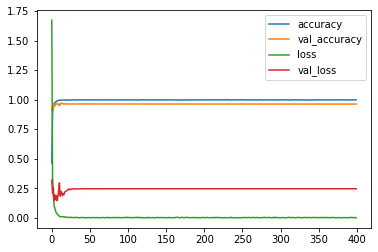

In [63]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()

# ConvNN(PCA) - top 300

## Train/Test split    

In [125]:
TC1data15_selected = TC1data15.loc[:,sum_loading.sort_values(ascending=False)[:300].index]

In [126]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [127]:
X_train

,OLFM4,IGHD,CST1,MINOS1P3,PRSS21,COX20P1,H19,MTND4P12,NTS,LTF,PLA2G2A,SST,RP11-109M17.2,ERAP2,HCG4P5,UPK1B,MSMB,COX6CP1,DEFB1,FABP4,NLRP2,IGLV8-61,CXCL5,RPS28P7,MSLN,EEF1A2,RP11-467L13.5,IGLV10-54,IGLV4-60,C1DP1,PIGR,RP11-305M3.2,CD177,IGHG4,FDCSP,LGALS7,SPESP1,IGF2,SCGB1A1,CXCL14,...,CTAG2,RP11-206M11.7,GPX2,FCGBP,CCL18,IGKV6D-21,PIP,KLK11,KLK6,HOXC10,IGHV4-4,FGB,NEFL,GAL,IGLV3-21,VNN1,SLPI,AMTN,UGT2B17,PRSS3,SAA1,PCDHGA10,IGHV3-43,RP11-297P16.4,CA12,C2orf54,WDR72,IGKV5-2,NMU,NUPR1L,RPL39L,CXCL6,MGST1,MMP3,CRABP2,MMP12,IGHA2,GPAT2,CTA-384D8.31,VTCN1
849,0.000000,3.451720,1.924427,1.214701,0.034128,0.796983,0.000000,0.241386,0.000000,0.955123,1.115573,0.000000,0.000000,1.494122,0.000000,0.000000,0.000000,0.358672,0.534561,0.000000,0.000000,2.116817,0.425798,2.638663,3.431951,1.762916,0.000000,2.168452,1.768109,1.096429,1.691947,0.938032,0.000000,2.661443,1.421802,0.000000,0.000000,1.008352,1.507239,1.348174,...,0.0,0.000000,2.520775,0.925476,2.489023,1.107416,0.000000,0.759562,0.000000,1.406353,0.531705,0.959357,0.168666,0.000000,3.052650,0.231438,3.612812,0.000000,0.000000,0.000000,0.704465,0.000000,1.472290,0.000000,0.354215,1.127222,0.082539,1.212567,0.687382,0.000000,1.187233,0.000000,2.715825,0.000000,2.681216,0.724169,3.432900,0.000000,0.143028,0.685608
1050,0.000000,0.891166,0.070649,0.000000,0.000000,1.087995,0.589354,2.247298,0.000000,2.601139,0.000000,0.000000,0.000000,1.327797,0.895526,0.411449,0.434593,1.299270,0.561074,0.000000,0.000000,0.447410,2.245163,2.926227,1.924036,1.196526,1.149015,0.201088,1.191099,0.937306,0.016960,0.140908,0.000000,0.820715,0.359019,0.000000,0.000000,0.658734,0.000000,1.471142,...,0.0,2.331532,0.677756,1.400181,2.060181,0.417925,2.267888,0.000000,1.414726,0.277530,0.000000,0.000000,0.000000,2.163065,1.526897,1.169651,2.694524,0.000000,0.000000,1.531403,1.927743,0.000000,0.354370,0.000000,1.289541,0.000000,0.000000,0.339807,0.332531,0.000000,2.164836,0.666409,1.967046,0.658254,2.199999,2.075464,2.382251,0.000000,2.269779,2.263385
835,0.000000,1.241689,2.417806,1.595289,1.401257,0.267332,1.108554,2.232516,3.162791,0.936211,0.000000,0.000000,0.924735,0.631624,0.883749,0.543921,0.031125,0.186532,1.641631,0.629357,0.000000,1.326851,0.000000,3.019834,0.130461,0.770522,0.000000,0.720105,0.000000,0.000000,1.153434,0.253478,0.192738,2.192938,1.541400,1.804994,1.596873,1.000693,2.067914,3.207606,...,0.0,0.000000,3.450378,0.261245,1.577894,0.000000,0.000000,0.996138,0.781892,0.982658,0.561592,0.000000,0.606858,0.000000,1.821441,0.000000,2.502938,2.232032,0.115347,0.443945,0.334279,0.018825,0.328638,1.011512,1.842113,0.000000,1.208723,0.000000,0.775478,0.000000,1.575012,0.000000,0.678401,0.088454,2.865003,1.300814,2.024221,0.000000,0.000000,1.764685
4447,0.000000,0.314609,2.389053,0.000000,0.000000,0.000000,1.863976,0.590006,0.279646,0.000000,0.083925,0.000000,0.107764,1.177361,0.000000,0.000000,0.000000,0.000000,0.000000,0.283025,0.000000,2.481546,0.580356,3.275798,0.312685,2.387843,0.735262,0.063985,1.574975,0.000000,0.000000,0.000000,0.103225,2.612143,0.000000,0.000000,0.000000,2.591494,0.000000,2.622154,...,0.0,0.000000,2.273950,0.375970,1.374103,0.315585,0.000000,0.000000,0.000000,0.000000,0.861459,0.000000,0.000000,1.171934,2.621442,0.000000,0.674940,0.000000,1.265490,0.713333,1.032651,0.000000,1.493938,0.000000,1.660267,0.378461,0.000000,1.761213,0.000000,0.000000,0.366889,1.295114,1.782123,1.179261,2.802413,1.313344,3.138005,0.000000,0.000000,0.516333
53,0.000000,0.124001,0.848674,0.000000,2.321561,0.514690,0.000000,1.153314,0.320263,0.424957,0.372927,1.334508,0.536945,0.704182,1.708493,0.261167,0.000000,0.166718,2.422981,0.000000,0.014891,0.890756,0.685729,2.145886,2.660830,1.522546,1.229384,0.970287,0.054391,0.125379,1.278695,0.166718,0.000000,0.708005,0.000000,0.000000,0.000000,2.255922,0.000000,0.676345,...,0.0,0.000000,0.000000,0.466422,0.823782,0.000000,0.538180,1.701283,2.459654,0.842577,0.326178,0.000000,0.000000,0.737395,1.455956,1.078100,3.761177,0.000000,0.000000,0.000000,2.74508

## CONV1D 

In [128]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=100

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [129]:
# X_train shape: (3375, 300)
# X_test shape:  (1125, 300)
# Y_train shape: (3375,15)
# Y_test shape:  (1125,15)

# 300
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# X_train shape: (3375, 300, 1)
# X_test shape:  (1125, 300, 1)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [130]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# x_train_len = 300
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 281, 128)          2688      
_________________________________________________________________
activation (Activation)      (None, 281, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 281, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 272, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 272, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0

In [131]:
# save
save = '.'
output_dir = "Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [132]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [133]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/100
169/169 [==============================] - ETA: 0s - loss: 1.7351 - acc: 0.4501
Epoch 00001: val_loss improved from inf to 0.48831, saving model to Model/tc1.autosave.model.h5
169/169 [==============================] - 16s 97ms/step - loss: 1.7351 - acc: 0.4501 - val_loss: 0.4883 - val_acc: 0.8400
Epoch 2/100
169/169 [==============================] - ETA: 0s - loss: 0.3999 - acc: 0.8759
Epoch 00002: val_loss improved from 0.48831 to 0.30172, saving model to Model/tc1.autosave.model.h5
169/169 [==============================] - 16s 93ms/step - loss: 0.3999 - acc: 0.8759 - val_loss: 0.3017 - val_acc: 0.9120
Epoch 3/100
169/169 [==============================] - ETA: 0s - loss: 0.2437 - acc: 0.9283
Epoch 00003: val_loss improved from 0.30172 to 0.25825, saving model to Model/tc1.autosave.model.h5
169/169 [==============================] - 16s 93ms/step - loss: 0.2437 - acc: 0.9283 - val_loss: 0.2583 - val_acc: 0.9227
Epoch 4/100
169/169 [==============================] - ETA:

In [134]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.3075293302536011
Test accuracy: 0.9520000219345093


Text(0, 0.5, 'epoch')

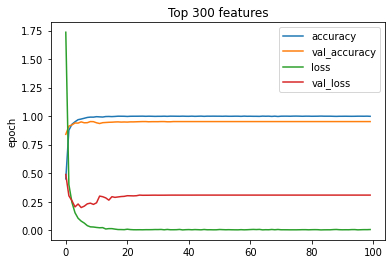

In [135]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("Top 300 features")
plt.ylabel('epoch')
